In [1]:
import os
import time
import itertools

from torchvision.transforms import v2
from sklearn.model_selection import train_test_split, StratifiedKFold
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
from tqdm import tqdm
import mediapy as media

%load_ext autoreload
%autoreload 2
    
from data_loaders import *
from training_utils import *
from cnn_model import *
from vae_model import *

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
torchvision.disable_beta_transforms_warning()

/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <38796DC6-8F33-3A89-BBAA-5FC71F99817A> /Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints a

In [2]:
def get_dataset_preview(dataset, idxs, title, sample_idxs, nrows, ncols, ax, idx_to_plot=0):
    imgs = np.zeros((nrows * 32, ncols * 32))
    assert len(sample_idxs) == nrows * ncols
    xy_indices = itertools.product(range(nrows), range(ncols))
    for i, (row, col) in enumerate(xy_indices):
        idx = sample_idxs[i]
        X, Y = dataset[idx]
        curr = X[idx_to_plot].reshape(32,32)
        imgs[row*32:(row+1)*32, col*32:(col+1)*32] = curr.numpy()
    ax.imshow(imgs, vmin=-1, vmax=1, cmap='icefire')
    ax.set_title(title)

def get_pixel_dist(dataset, idxs, title, sample_idxs, ax, idx_to_plot=0):
    imgs = np.empty((nsamples, 32, 32))
    for i, idx in enumerate(sample_idxs):
        X, Y = dataset[idx]
        curr = X[idx_to_plot].reshape(32,32)
        imgs[i] = curr.numpy()
    sns.histplot(imgs.ravel(), stat='density', ax=ax, label=idx_to_plot, binrange=[-1,1])
    ax.legend()
    ax.set_title(title)


def get_cloudy_stats(data, idx):
    filtered_data = data.iloc[idx]
    clear_data = filtered_data.loc[filtered_data['label'] == 'clear_night_sky']
    cloudy_data = filtered_data.loc[filtered_data['label'] == 'not_clear_cloudy']
    prop_clear = len(clear_data) / len(filtered_data)
    prop_cloudy = len(cloudy_data) / len(filtered_data)
    return len(cloudy_data), prop_cloudy


def print_class_dist(dataset):
    data = dataset.dsl_df
    ncloudy, prop_cloudy = get_cloudy_stats(data, np.arange(len(data)))
    unique_module_ids = list(np.sort(data["module_id"].unique()))
    print(f'Percent cloudy = {100 * prop_cloudy:.3f}% ({ncloudy} / {len(data)}); '
          f'Unique module_ids: {unique_module_ids}')

def show_dataset_sample(dataset, nrows:int=5, ncols:int=15):
    data_fig, data_axs = plt.subplots(2, 1, figsize=(ncols*1.2, nrows*2))
    data_fig.tight_layout()
    
    nsamples = nrows * ncols
    idxs = np.arange(len(dataset))
    sample_idxs = np.random.choice(idxs, nsamples, replace=False)
    
    if len(sample_idxs) < nsamples:
        print('Not enough training data')
    
    # img_types = {
    #     0: 'FFT of Derivative',
    #     1: 'Orig(t) @ 3ms',
    #     2: 'Orig(t) - Orig(t-60s)',
    #     3: 'FFT of Orig(t)'
    # }
    
    img_types = {
        0: 'FFT of Derivative',
        1: 'FFT of Orig(t)'
    }
    
    for img_type_idx in range(1, 3):
        img_type_idx = img_type_idx % 2
        img_type = img_types[img_type_idx]
        get_dataset_preview(
            dataset,
            idxs,
            title=img_type,
            sample_idxs=sample_idxs,
            nrows=nrows,
            ncols=ncols,
            ax=data_axs[img_type_idx - 1],
            idx_to_plot=img_type_idx
        )
    plt.show(data_fig)
    plt.close(data_fig)

In [3]:
# Training helper functions
def make_training_loss_plot(log_dict, figsize=(9,6)):
    """Plot training loss vs step"""
    epoch = log_dict['Epoch'][-1]
    log_df = pd.DataFrame.from_dict(log_dict)
    plt.figure(figsize=figsize)
    sns.lineplot(
        log_df,
        x='Step',
        y='Loss',
        errorbar=None,
    )
    ax = plt.gca()
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    plt.grid(True, which="both", ls="-")
    plt.title(f'Training Loss After {epoch} Epochs')
    plt.show()

def get_device(verbose=False):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    if verbose: print(f"Using device {device}")
    return device

In [4]:
# Forward method
def vae_forward(
    vae: VaeModel,
    X: torch.Tensor,
) -> torch.Tensor:
    """
    Args:
        vae: VAE model
        X: (N, C, 32, 32) input tensor of Cx32x32 images

    Returns:
        (,) vae loss.
    """
    # Apply positional encoding to input coordinates
    vae.train()
    recon_x, mu, logvar = vae.forward(X)
    return vae_loss(recon_x, X, mu, logvar)

# Sampling method
@torch.inference_mode()
def vae_sample(
    vae: VaeModel,
    nsamples: int,
    img_cwh: tuple[int, int],
    seed: int,
) -> torch.Tensor:
    """
    Args:
        vae: VAE model
        nsamples: number of images to create
        img_cwh: image dimensions (W, H)
    Returns:
        (,) 
    """
    vae.eval()
    device = get_device()
    with torch.no_grad():
        torch.manual_seed(seed)
        z = torch.randn(nsamples, vae.latent_dim).to(device)
        return vae.decode(z).cpu()

In [5]:
# VaeWrapper: one level of indirection to make experimentation on the fly easier

class VaeWrapper(nn.Module):
    def __init__(
        self,
        vae: VaeModel,
        input_img_cwh: tuple[int, int, int] = (1, 32, 32),
        seed: int = 180,
    ):
        super().__init__(),
        self.vae = vae
        self.img_cwh = input_img_cwh
        self.seed = seed
        
    def forward(self, X: torch.Tensor):
        """
        Args:
            X: (N, C, 32, 32) input tensor of C x 32 x 32 images

        Returns:
            (,) VAE loss.
        """
        self.vae.train()
        assert X[0].shape == torch.Size(self.img_cwh), f"X.shape={X.shape} but img_cwh={img_cwh}"
        return vae_forward(self.vae, X)

    @torch.inference_mode()
    def sample(
        self,
        nsamples: int = 16,
    ):
        self.vae.eval()
        return vae_sample(self.vae, nsamples, self.img_cwh, self.seed)

In [28]:
# Train Neural Field TODO: fix it.
hyperparam_config = {
    'latent_dim': 256,
    'num_epochs': 50,
    'batch_size': 64,
    'gamma': 0.95,
    'lr': 1e-3,
    'weight_decay': 1e-5,
}

def train_vae(
    hpc,
    img_cwh = (2, 32, 32),
    seed = 180,
    verbose=True,
):
    device = get_device()
    ### Create panoseti dataloader
    mean = [7.4, 7.4]
    std = [5.5, 5.5] 
    
    transform = v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        v2.Normalize(mean=mean, std=std),
        v2.ToDtype(torch.float),
    ])
    train_labeled_data = CloudDetectionTrain(transform=transform)
    train_loader = torch.utils.data.DataLoader(
        dataset = train_labeled_data,
        batch_size = hpc['batch_size'],
        sampler=torch.utils.data.SubsetRandomSampler(
            np.random.choice(np.arange(len(train_labeled_data)), replace=False, size=3000),
        )
    )
    if verbose:
        show_dataset_sample(train_labeled_data, nrows=2, ncols=15)
        print_class_dist(train_labeled_data)
    
    ### Model training config
    num_channels = img_cwh[0]
    model = VaeWrapper(
        vae = VaeModel(num_channels, hpc['latent_dim']),
        input_img_cwh = img_cwh,
        seed = seed,
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=hpc['lr'])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=hpc['gamma'])

    ### Train Model
    log_dict = {
        'Step': [],
        'Loss': [],
        'Epoch': []
    }
    os.makedirs('vae_model', exist_ok=True)
    
    step = 0
    for epoch in range(1, hpc['num_epochs'] + 1):
        torch.manual_seed(seed + epoch)
        for x, y in tqdm.tqdm(train_loader, unit="batch"):
            step += 1
            model.train()
            x = x.to(device)

            optimizer.zero_grad()
            loss = model(x)
            loss.backward()
            optimizer.step()
    
            if step % 5 == 0: 
                log_dict['Epoch'].append(epoch)
                log_dict['Step'].append(step)
                log_dict['Loss'].append(np.abs(loss.item()))
        
        # Update learning rate
        scheduler.step()
        
        # Make figures for this Epoch
        print(f'Epoch {epoch}\n')
        if (epoch - 1) % 5 == 0: 
            plot_sample(model)
            torch.save(model, f"vae_model/vae_nepoch={epoch}_ldim={hpc['latent_dim']}")
        # if (epoch - 1) % 20 == 0:
            # make_training_loss_plot(log_dict)
    
    log_df = pd.DataFrame.from_dict(log_dict)
    make_training_loss_plot(log_dict)
    plot_sample(model)
    return model, log_df

In [29]:
def plot_sample(model: VaeWrapper, nrows=1, ncols=5):
    nsamples = nrows * ncols
    sampled_images = model.sample(nsamples = nsamples)
    assert len(sampled_images) == nrows * ncols
    imgs = np.zeros((nrows * 32, ncols * 32))
    xy_indices = itertools.product(range(nrows), range(ncols))
    for i, (row, col) in enumerate(xy_indices):
        curr = sampled_images[i, 0, ...].reshape(32,32)
        imgs[row*32:(row+1)*32, col*32:(col+1)*32] = curr.numpy()
    plt.imshow(imgs, vmin=-1, vmax=1, cmap='icefire')
    plt.show()
    
    

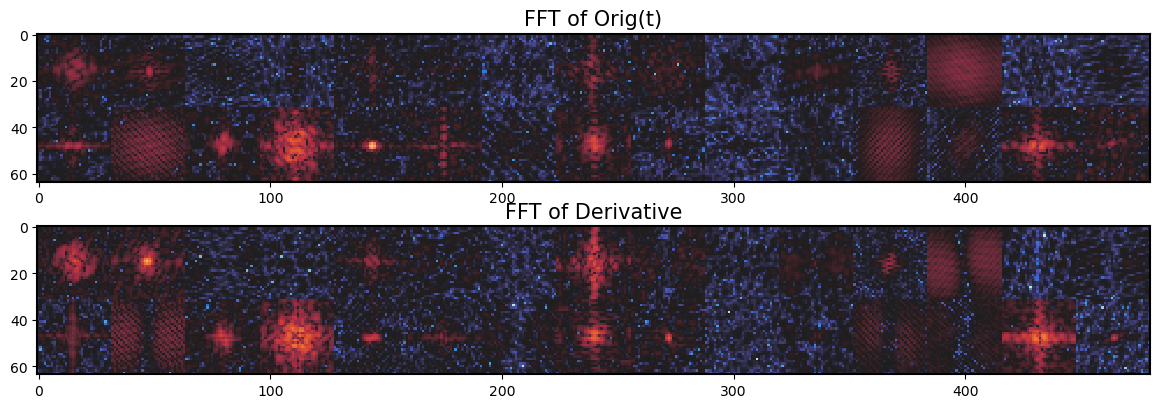

Percent cloudy = 53.962% (12551 / 23259); Unique module_ids: [1, 3, 254]


  0%|          | 0/47 [00:00<?, ?batch/s]

In [ ]:
hyperparam_config = {
    'latent_dim': 256,
    'num_epochs': 50,
    'batch_size': 64,
    'gamma': 0.95,
    'lr': 1e-3,
    'weight_decay': 1e-5,
}

model, log_df = train_vae(
    hyperparam_config,
    img_cwh = (2, 32, 32),
    seed = 180,
    verbose = True
)